# Analytic verification for heat  equation solver



In [6]:
%matplotlib inline  
#%matplotlib qt
import numpy as np  
import matplotlib.pyplot as plt
import scipy as sc
import scipy.integrate as integrate

In [26]:
plt.rc('font', family='serif', size = '11')
plt.rc('text', usetex=True)

## Functions

In [2]:
def create_matrix(R,T,H,dt,mode="base_temp"):
    """
    Ouputs tridag and source coefficients necessary
    to solve the tridiagonal matrix system
    """ 
    n = T.shape[1]
    dr = R[1]-R[0]
    D = [1 for k in range(n+1)] #n+1 because we enter T[:n-1]
    Cp = [1 for k in range(n+1)]
    
    Diagonals = np.zeros((4,n))
    if mode == "base_temp":
        Diagonals[0,0] = 0   # ct
        Diagonals[1,0] = 1 # bt
        Diagonals[2,0] = 0   # at
        Diagonals[3,0] = T[0,0]
    
    elif mode == "base_flux":
        Diagonals[0,0] = -D[0]*dt/(R[1]-R[0])**2     # ct
        Diagonals[1,0] = 1/2 +D[0]*dt/(R[1]-R[0])**2 # bt
        Diagonals[2,0] = 0                           # at
        Diagonals[3,0] = 0.5*T[0,0]                  # st
    
    for i in range(1,n-1):
        Dp = (D[i]+D[i+1])/2 # D_i+1/2
        Dm = (D[i-1]+D[i])/2 # D_i-1/2
        
        Diagonals[0,i] = -dt/(R[i+1]-R[i-1])*(D[i]/R[i] + Dp/(R[i+1]-R[i]))#DiagU
        Diagonals[1,i] = 0.5 + dt/(R[i+1]-R[i-1])*(Dp/(R[i+1]-R[i]) + Dm/(R[i]-R[i-1]))
        Diagonals[2,i] = dt/(R[i+1]-R[i-1])*(D[i]/R[i] - Dm/(R[i]-R[i-1])) #DiagL   
        Diagonals[3,i] = 0.5*T[0,i]+H[i]*dt/2/Cp[i]
    
    Diagonals[0,n-1] = 0
    Diagonals[1,n-1] = 1
    Diagonals[2,n-1] = 0
    Diagonals[3,n-1] = T[0,n-1]
    
    return(Diagonals)

In [3]:
def tridag(at,bt,ct,rt,u):
    """
    Solve tridiagonal matrix M*u=rt
    n is the size of the square matrix
    returns the solution vector u
    """
    n = np.size(rt)
    gamt = [0 for k in range(n)]
 
    bett = bt[0]
    u[0] = rt[0]/bett
    for j in range(1,n):
        gamt[j] = ct[j-1] / bett
        bett = bt[j]-at[j]*gamt[j]
        u[j] = (rt[j]-at[j]*u[j-1]) / bett
    
    for j in range(n-2,-1,-1):
        u[j] = u[j]-gamt[j+1]*u[j+1]  
    return(u)

In [4]:
def start_conduction(R, T, H ,time=0.1, dt=0.001, n=50, mode="base_temp"):

    # Loop over timesteps
    for i in range(int(time/dt)):
        T[0,:] = T[1,:]
        #print('time = {}'.format((i+1)*dt))
        Diagonals = create_matrix(R,T[:,:],H,dt,mode) # Create tridag system of equations 
        T[1,:] = tridag(Diagonals[2],Diagonals[1],Diagonals[0],Diagonals[3],T[1,:]) # Solve system
    return(T)

---
### Hollow sphere test

In [7]:
# Time parameters
time = 1
dt = time/1e3

# Raidus 
n = 100
a, b = 1/2, 1
#R = np.array([a + k*(b-a)/(n-1) for k in range(n)])
R = [a + np.sin(k*np.pi/2/(n-1))/2 for k in range(n)]

# Tidal Heat
H = [0 for k in range(n)]

# Temperature profile
Ts = 1
Tb = 1/2
T = np.zeros((2,n))
#f = lambda r : np.sin(np.pi*(r-a)/2/(b-a))*(Tb-Ts) + Ts
f = lambda r: (2**((r-a)**4/(b-a)**4)-1)*(Tb-Ts)+Ts
T[1] = [f(r) for r in R]

#Call function
T = start_conduction(R, T, H, time, dt, n, mode="base_temp")

# Solution
v1, v2 = Ts, Tb
D = 1000
t = time
g = lambda r: a*v1/r + (b*v2-a*v1)*(r-a)/r/(b-a) + 2/r/np.pi*sum([(b*v2*np.cos(n*np.pi)-a*v1)/n*np.sin(n*np.pi*(r-a)/(b-a))*np.exp(-D*n**2*np.pi**2*t/(b-a)**2) for n in range(1,10)])+ 2/r/(b-a)*sum([np.sin(n*np.pi*(r-a)/(b-a))*np.exp(-D*n**2*np.pi**2*t/(b-a)**2)*integrate.quad(lambda x: x*f(x)*np.sin(n*np.pi*(x-a)/(b-a)), a,b)[0] for n in range(1,10)])
Solution = [g(r) for r in R[1:]]

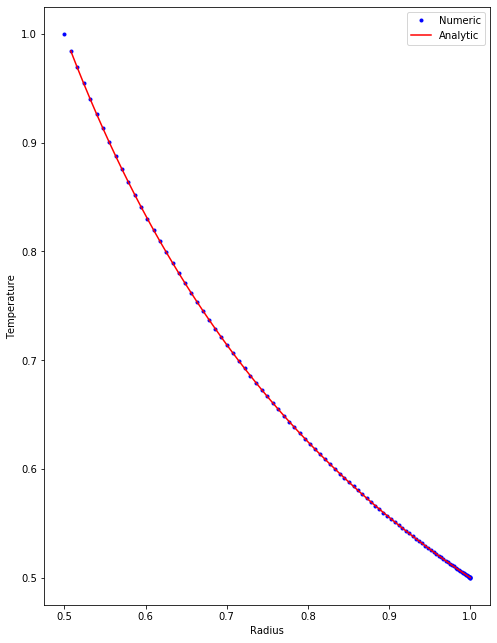

In [8]:
#Plot
fig, ax = plt.subplots(figsize=(4*2,5.5*2))
ax.plot(R,T[1,:],'.',color='blue', label = "Numeric")
ax.plot(R[1:],Solution, color = 'red', label = "Analytic")
ax.set_xlabel("Radius")
ax.set_ylabel(r"Temperature")
plt.legend()
#plt.savefig("../figures/sphere_tf={0}_dt={1}.pdf".format(time,dt))
plt.show()

In [16]:
Pintern = 0
for i in range(len(H)-1):
    Pintern += (H[i]+H[i+1])/2*4*np.pi*((R[i]+R[i+1])/2)**2*(-R[i]+R[i+1])
    
print("Pintern= ", Pintern)

Pintern=  0.0


In [196]:
k = 1
P_base = k*(T[1,0]-T[1,1])/(R[0]-R[1])*4*np.pi*R[0]**2
P_surf = k*(T[1,n-1]-T[1,n-2])/(R[n-1]-R[n-2])*4*np.pi*R[n-1]**2
print("P_base - P_surf = ", P_base - P_surf)

Error_2pt.append(abs(Pintern -(P_base - P_surf)))

P_base - P_surf =  0.019732232873738376


In [197]:
# Calcul des flux
Delta1 =   R[1] - R[0]
Delta11 =  R[2] - R[0]
DT1 = (Delta11**2*T[1,1]-Delta1**2*T[1,2]-(Delta11**2-Delta1**2)*T[1,0])/(Delta11**2*Delta1-Delta1**2*Delta11)
P_base = k*DT1*4*np.pi*R[0]**2
Delta1 =   R[n-2] - R[n-1]
Delta11 =  R[n-3] - R[n-1]
DTn = (Delta11**2*T[1,n-2]-Delta1**2*T[1,n-3]-(Delta11**2 -Delta1**2)*T[1,n-1])/(Delta11**2*Delta1-Delta1**2*Delta11)
P_surf = k*DTn*4*np.pi*R[n-1]**2
print("P_base - P_surf = ", (P_base - P_surf), "TW")

Error_3pt.append(abs(Pintern -(P_base - P_surf)))

P_base - P_surf =  0.00012335384882788958 TW


In [169]:
#Error_2pt = []
#Error_3pt = []

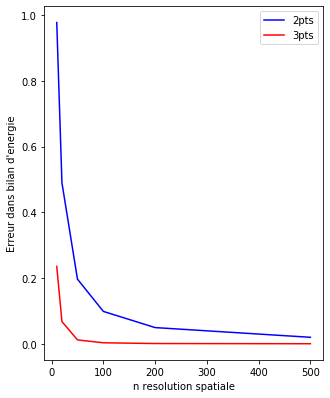

In [198]:
#Plot
n =[10,20,50,100,200,500] 
fig, ax = plt.subplots(figsize=(5,6.5))
ax.plot(n,Error_2pt,color='blue', label = "2pts")
ax.plot(n,Error_3pt, color = 'red', label = "3pts")
ax.set_xlabel("n resolution spatiale")
ax.set_ylabel(r"Erreur dans bilan d'energie")
plt.legend()
plt.savefig("error_nrj_hollowspheretest.png")
plt.show()

---
### Sphere Test

In [9]:
# Time parameters
time = 0.1
dt = 0.0001

# Raidus and Tidal Heat
n = 50
l = 1 
#R = [(2**(k/(n-1))-1) for k in range(n) ]
#R = [np.sin(k*np.pi/2/(n-1)) for k in range(n)]
R = np.array([(k+0)*l/(n-1) for k in range(n)])
H = [0 for k in range(n)]

# Temperature profile
Ts = 1
T = np.zeros((2,n))
T[1,n-1] = Ts
#T_ini = T[0,:]

#Call function
T = start_conduction(R, T, H, time, dt, n, mode="base_flux")

D = 1
V = 1
l = 1
t = time
g = lambda r: V + 2*l*V/np.pi/r *sum([np.exp(-D*n**2*np.pi**2*t/l**2)*(-1)**n /n *np.sin(n*np.pi*r/l) for n in range(1,1000)])
Solution = [g(r) for r in R[1:]]

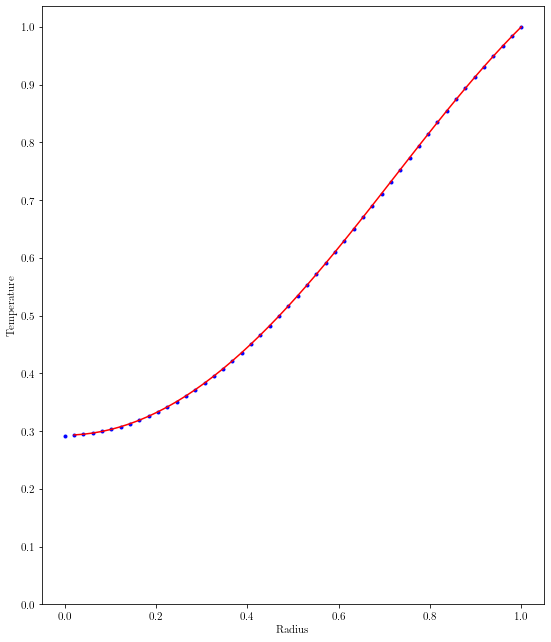

In [25]:
#Plot
fig, ax = plt.subplots(figsize=(9,11))
ax.plot(R,T[1,:],'.',color='blue') #,label='{}'.format(D*t/l**2))
ax.plot(R[1:],Solution, color = 'red')
ax.set_xlabel("Radius")
ax.set_ylabel(r"Temperature")
ax.set_yticks([k/10 for k in range(11)])
#plt.legend()
#plt.title('Temps final = {0}, Pas de temps = {1}'.format(time,dt))
#plt.savefig("../figures/sphere_tf={0}_dt={1}.pdf".format(time,dt))
plt.show()

---
## Heat test

In [142]:
# Time parameters
time = 1
dt = time/1e3

# Radius
n = 800
l = 1 
R = np.array([(k+0)*l/(n-1) for k in range(n)])

# Heat
H0 = 1  
heat_fct = lambda r: H0/r*np.sin(np.pi*r/l)
H = [heat_fct(r) for r in R[1:]]
H.insert(0, H0*np.pi/l)

# Temperature profile
Ts = 0
T = np.zeros((2,n))

#Call function
T = start_conduction(R, T, H, time, dt, n, mode="base_flux")

D = 1
V = 1
l = 1
k = 1
t = time
g = lambda r: H0*l**2/(np.pi**2*k*r)*(1-np.exp(-D*np.pi**2*t/l**2))*np.sin(np.pi*r/l) 
Solution = [g(r) for r in R[1:]]

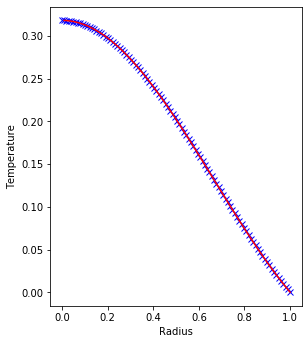

In [110]:
#Plot
fig, ax = plt.subplots(figsize=(4.5,5.5))
ax.plot(R,T[1,:],'x',color='blue') #,label='{}'.format(D*t/l**2))
ax.plot(R[1:],Solution, color = 'red')
ax.set_xlabel("Radius")
ax.set_ylabel(r"Temperature")
#ax.set_yticks([k/10 for k in range(11)])
#plt.legend()
#plt.savefig("../figures/InternHeat_test.pdf")
plt.show()

In [143]:
Pintern = 0
for i in range(len(H)-1):
    Pintern += (H[i]+H[i+1])/2*4*np.pi*((R[i]+R[i+1])/2)**2*(-R[i]+R[i+1])
    
print("Pintern= ", Pintern)

Pintern=  4.000003960146631


In [144]:
k = 1
P_base = k*(T[1,0]-T[1,1])/(R[0]-R[1])*4*np.pi*R[0]**2
P_surf = k*(T[1,n-1]-T[1,n-2])/(R[n-1]-R[n-2])*4*np.pi*R[n-1]**2
print("P_base - P_surf = ", P_base - P_surf)

Error_2pt.append(abs(Pintern -(P_base - P_surf)))

P_base - P_surf =  4.004789947269422


In [145]:
# Calcul des flux
Delta1 =   R[1] - R[0]
Delta11 =  R[2] - R[0]
DT1 = (Delta11**2*T[1,1]-Delta1**2*T[1,2]-(Delta11**2-Delta1**2)*T[1,0])/(Delta11**2*Delta1-Delta1**2*Delta11)
P_base = k*DT1*4*np.pi*R[0]**2
Delta1 =   R[n-2] - R[n-1]
Delta11 =  R[n-3] - R[n-1]
DTn = (Delta11**2*T[1,n-2]-Delta1**2*T[1,n-3]-(Delta11**2 -Delta1**2)*T[1,n-1])/(Delta11**2*Delta1-Delta1**2*Delta11)
P_surf = k*DTn*4*np.pi*R[n-1]**2
print("P_base - P_surf = ", (P_base - P_surf), "TW")

Error_3pt.append(abs(Pintern -(P_base - P_surf)))

P_base - P_surf =  3.9997961123133545 TW


In [108]:
#Error_2pt = []
#Error_3pt = []

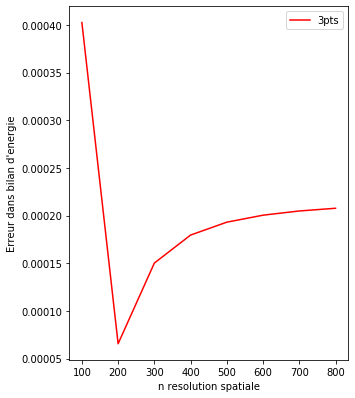

In [150]:
#Plot
n =[100,200,300,400,500,600,700,800] 
fig, ax = plt.subplots(figsize=(5,6.5))
#ax.plot(n,Error_2pt,color='blue', label = "2pts")
ax.plot(n,Error_3pt, color = 'red', label = "3pts")
ax.set_xlabel("n resolution spatiale")
ax.set_ylabel(r"Erreur dans bilan d'energie")
plt.legend()
plt.savefig("error_nrj_heattest_3pts.png")
plt.show()

---
## Linear profile test

In [43]:
# Time parameters
time = 0.2
dt = time/1e3

# Radius
n = 100
l = 1 
R = np.array([(k+0)*l/(n-1) for k in range(n)])
#R = [np.sin(k*np.pi/2/(n-1)) for k in range(n)]

# Heat
H = [0 for k in range(n)]

D = 1
V = 1
# Temperature profile
Ts = 0
T = np.zeros((2,n))
f = lambda r : V*(l-r)/l
T[1] = [f(r) for r in R[:]]
T_ini[:] = T[1,:]

#Call function<
T = start_conduction(R, T, H, time, dt, n, mode="base_flux")

t = time
g = lambda r: 8*l*V/r/np.pi**3*sum([np.exp(-D*(2*n+1)**2*np.pi**2*t/l**2)*np.sin((2*n+1)*np.pi*r/l)/(2*n+1)**3 for n in range(1000)])
Solution = [g(r) for r in R[1:]]

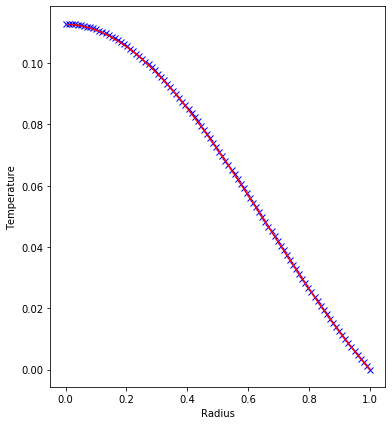

In [44]:
#Plot
fig, ax = plt.subplots(figsize=(6,7))
ax.plot(R,T[1,:],'x',color='blue') #,label='{}'.format(D*t/l**2))
ax.plot(R[1:],Solution, color = 'red')
#ax.plot(R,T_ini,'-',color='orange',) #,label='{}'.format(D*t/l**2))
ax.set_xlabel("Radius")
ax.set_ylabel(r"Temperature")
#plt.legend()
#plt.savefig("../figures/Tcrust_profile.pdf")
plt.show()

In [58]:
0.0001/0.05

0.002

---
## Draw complete hollow sphere 

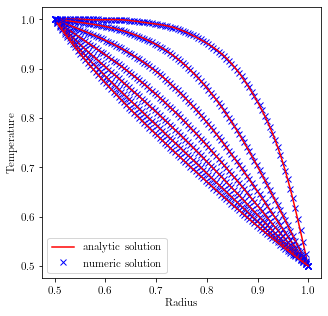

In [63]:
# Time parameters
time = 0.05
dt = 0.0001

# Raidus and Tidal Heat
n = 100
a = 1/2 
b = 1
R = np.array([a + k*(b-a)/(n-1) for k in range(n)])
#R = [a + np.sin(k*np.pi/2/(n-1))/2 for k in range(n)]
H = [0 for k in range(n)]

# Temperature profile
Ts = 1
Tb = 1/2
T = np.zeros((2,n))
#f = lambda r : np.sin(np.pi*(r-a)/2/(b-a))*(Tb-Ts) + Ts
f = lambda r: (2**((r-a)**4/(b-a)**4)-1)*(Tb-Ts)+Ts
T[1] = [f(r) for r in R]

mode =  "base_temp"

#Plot
#fig,(ax,ax_r) = plt.subplots(1,2,figsize=(13,7))
fig,ax = plt.subplots(figsize=(5,5))

# Call functions
for i in range(int(time/dt)):
    T[0,:] = T[1,:]
    #print('time = {}'.format((i+1)*dt))
    Diagonals = create_matrix(R,T[:,:],H,dt,mode)
    T[1,:] = tridag(Diagonals[2],Diagonals[1],Diagonals[0],Diagonals[3],T[1,:])
    
    if i%80 == 0:
        v1 = Ts
        v2 = Tb
        D = 1
        t = (i+1)*dt
        g = lambda r: a*v1/r + (b*v2-a*v1)*(r-a)/r/(b-a) + 2/r/np.pi*sum([(b*v2*np.cos(n*np.pi)-a*v1)/n*np.sin(n*np.pi*(r-a)/(b-a))*np.exp(-D*n**2*np.pi**2*t/(b-a)**2) for n in range(1,10)])+ 2/r/(b-a)*sum([np.sin(n*np.pi*(r-a)/(b-a))*np.exp(-D*n**2*np.pi**2*t/(b-a)**2)*integrate.quad(lambda x: x*f(x)*np.sin(n*np.pi*(x-a)/(b-a)), a,b)[0] for n in range(1,10)])
        Solution = [g(r) for r in R[1:]]
        
        ax.plot(R,T[1,:],'x',color='blue') #,label='{}'.format(D*t/l**2))
        ax.plot(R[1:],Solution, color = 'red')
  

ax.lines[-3].set_label('analytic solution')
ax.lines[-2].set_label('numeric solution')
ax.set_xlabel("Radius")
ax.set_ylabel(r"Temperature")
ax.legend()

#ax_r.plot([k for k in range(len(R))],R, label="Radius Profile")
#ax_r.set_ylabel("Radius(n)")
#ax_r.set_xlabel("n")
#ax_r.legend()
#plt.savefig("../../figures/hollowsphere.pdf")

plt.show()

In [60]:
T[1,:]

array([1.        , 0.99224816, 0.98464759, 0.97719164, 0.96987391,
       0.96268826, 0.95562881, 0.94868987, 0.94186602, 0.93515202,
       0.92854286, 0.92203372, 0.91561999, 0.90929721, 0.90306115,
       0.8969077 , 0.89083297, 0.8848332 , 0.87890478, 0.8730443 ,
       0.86724844, 0.86151405, 0.85583814, 0.8502178 , 0.84465031,
       0.83913304, 0.83366349, 0.82823928, 0.82285815, 0.81751795,
       0.81221664, 0.80695227, 0.80172303, 0.79652718, 0.79136307,
       0.78622919, 0.78112407, 0.77604635, 0.77099478, 0.76596815,
       0.76096537, 0.75598541, 0.75102732, 0.74609023, 0.74117333,
       0.73627591, 0.7313973 , 0.72653691, 0.72169421, 0.71686873,
       0.71206007, 0.70726788, 0.70249187, 0.69773181, 0.69298752,
       0.68825886, 0.68354575, 0.67884817, 0.67416612, 0.66949966,
       0.6648489 , 0.66021396, 0.65559504, 0.65099234, 0.64640612,
       0.64183668, 0.63728432, 0.63274939, 0.62823229, 0.62373341,
       0.61925319, 0.61479209, 0.61035059, 0.60592919, 0.60152

In [61]:
np.max(Solution-T[1,1:])

0.0035931982963969267

---
## Complete sphere test

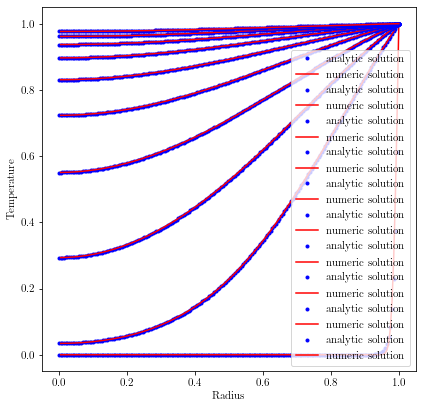

In [35]:
# Time parameters
time = 0.5
dt = 0.0001

# Raidus and Tidal Heat
n = 200
l = 1 
R = np.array([(k+0)*l/(n-1) for k in range(n)])
#R = [(2**(k**4/(n-1)**4)-1) for k in range(n) ]
#R = [np.sin(k*np.pi/2/(n-1)) for k in range(n)]

H = [0 for k in range(n)]


# Temperature profile
Ts = 1
T = np.zeros((2,n))
T[0,n-1] = Ts
T[1,n-1] = Ts
#T_ini = T[0,:]

mode = "base_flux"

#Plot
#fig,(ax,ax_r) = plt.subplots(1,2,figsize=(13,7))
fig,ax = plt.subplots(figsize=(6.7,6.7))
                      
# Call functions
for i in range(int(time/dt)):
    T[0,:] = T[1,:]
    #print('time = {}'.format((i+1)*dt))
    Diagonals = create_matrix(R,T[:,:],H,dt,mode)
    T[1,:] = tridag(Diagonals[2],Diagonals[1],Diagonals[0],Diagonals[3],T[1,:])  
    
    if i%500 == 0:
        t = (i+1)*dt
        D = 1
        V = 1
        l = 1
        g = lambda r: V + 2*l*V/np.pi/r *sum([np.exp(-D*n**2*np.pi**2*t/l**2)*(-1)**n /n *np.sin(n*np.pi*r/l) for n in range(1,1000)])
        Solution = [g(r) for r in R[1:]]
        ax.plot(R,T[1,:],'.',color='blue',label= "analytic solution")
        ax.plot(R[1:],Solution, color = 'red',label= "numeric solution")
  

ax.set_xlabel("Radius")
ax.set_ylabel(r"Temperature")
ax.legend()
#ax_r.plot([k for k in range(len(R))],R, label="Radius Profile")
#ax_r.set_ylabel("Radius(n)")
#ax_r.set_xlabel("n")
#ax_r.legend()


plt.savefig("../../figures/fullsphere_Rlinear.pdf")
plt.show()

---
### Older versions

In [ ]:
# Older version

"""def create_matrix(R,T,H,dt,Ts):
    """
    Ouputs tridag and source coefficients necessary
    to solve the tridiagonal matrix system
    tridag(Diagonals[2],Diagonals[1],Diagonals[0],Diagonals[3],T[1])
    """ 
    n = T.shape[1]
    dr = R[1]-R[0]
    D = [1 for k in range(n+1)] #n+1 because we enter T[:n-1]
    Cp = [1 for k in range(n+1)]
    
    Diagonals = np.zeros((4,n))
    Diagonals[0,0] = -D[0]*dt/(R[1]-R[0])**2     # ct
    Diagonals[1,0] = 1/2 +D[0]*dt/(R[1]-R[0])**2 # bt
    Diagonals[2,0] = 0                           # at
    Diagonals[3,0] = 0.5*T[0,0]+H[0]*dt/2/Cp[0]  # st
    
    for i in range(1,n):
        Dp = (D[i]+D[i+1])/2 # D_i+1/2
        Dm = (D[i-1]+D[i])/2 # D_i-1/2
        
        Diagonals[0,i] = -dt/(R[i+1]-R[i-1])*(D[i]/R[i] + Dp/(R[i+1]-R[i]))#DiagU
        Diagonals[1,i] = 0.5 + dt/(R[i+1]-R[i-1])*(Dp/(R[i+1]-R[i]) + Dm/(R[i]-R[i-1]))
        Diagonals[2,i] = dt/(R[i+1]-R[i-1])*(D[i]/R[i] - Dm/(R[i]-R[i-1])) #DiagL   
        Diagonals[3,i] = 0.5*T[0,i]+H[i]*dt/2/Cp[i]
        

    # n-1 boundary term
    Diagonals[3,n-1] = 0.5*T[0,n-1]+H[n-1]*dt/2/Cp[n-1] + dt/(R[n]-R[n-2])*(D[n-1]/R[n-1] + Dp/(R[n]-R[n-1]))*Ts 
    
    return(Diagonals)"""
"""
def create_matrix(R,T,H,dt,Ts):
    """
    Ouputs tridag and source coefficients necessary
    to solve the tridiagonal matrix system
    tridag(Diagonals[2],Diagonals[1],Diagonals[0],Diagonals[3],T[1])
    """ 
    n = T.shape[1]
    dr = R[1]-R[0]
    D = [1 for k in range(n)]
    Cp = [1 for k in range(n)]
    
    Diagonals = np.zeros((4,n))
    Diagonals[0,0] = -D[0]*dt/dr**2     # ct
    Diagonals[1,0] = 1/2 +D[0]*dt/dr**2  # bt
    Diagonals[2,0] = 0 #at
    Diagonals[3,0] = 0.5*T[0,0]+H[0]*dt/2/Cp[0]  # st
    
    for i in range(1,n-1):
        Dp = (D[i]+D[i+1])/2 # D_i+1/2
        Dm = (D[i-1]+D[i])/2 # D_i-1/2
        
        Diagonals[0,i] = -dt/2/dr**2*(D[i]/i + Dp )#DiagU
        Diagonals[1,i] = 0.5 + 0.5*dt/dr**2*(Dp+Dm) 
        Diagonals[2,i] = dt/2/dr**2*(D[i]/i - Dm) #DiagL
        Diagonals[3,i] = 0.5*T[0,i]+H[i]*dt/2/Cp[i]

    # n-1 boundary term
    Diagonals[0,n-1] = -dt/2/dr**2*D[n-1]*(1/(n-1) +1)#DiagU
    Diagonals[1,n-1] = 0.5 + D[n-1]*dt/dr**2 
    Diagonals[2,n-1] = dt/2/dr**2*D[n-1]*(1/(n-1) -1) #DiagL
    Diagonals[3,n-1] = 0.5*T[0,n-1]+H[n-1]*dt/2/Cp[n-1] + dt/2/dr**2*Ts*D[n-1]*(1/(n-1) + 1)
    
    return(Diagonals)
    
def create_matrix(R,T,H,dt,Ts):
    """
    Ouputs tridag and source coefficients necessary
    to solve the tridiagonal matrix system
    tridag(Diagonals[2],Diagonals[1],Diagonals[0],Diagonals[3],T[1])
    """ 
    n = T.shape[1]
    dr = R[1]-R[0]
    D = 1
    Cp = [1 for k in range(n)]
    
    Diagonals = np.zeros((4,n))
    Diagonals[0,0] = -D[0]*dt/dr**2     # ct
    Diagonals[1,0] = 1/2 +D[0]*dt/dr**2  # bt
    Diagonals[2,0] = 0 #at
    Diagonals[3,0] = 0.5*T[0,0]+H[0]*dt/2/Cp[0]  # st
    
    for i in range(1,n):
        Diagonals[0,i] = -dt/2/dr**2*D*(1/i+1)#DiagU
        Diagonals[1,i] = 0.5+dt*D/dr**2
        Diagonals[2,i] = dt/2/dr**2*D*(1/i-1) #DiagL
        Diagonals[3,i] = 0.5*T[0,i]+H[i]*dt/2/Cp[i]

    Diagonals[3,n-1] = 0.5*T[0,n-1] + H[n-1]*dt/2/Cp[n-1] + dt/2/dr**2*Ts*(1/(n-1)+1)
    
    return(Diagonals)
"""

In [35]:
365*86400

31536000